# AIDMS Problem Set 6 - Problem 2

This notebook explores the concept of differential privacy (DP) using Census data.  

Similar to the activity in Recitation 6, we will train a logistic regression classifier with and without DP. However, in this problem, we will apply a membership inference attack (i.e. where an adversary tries to determine if an individual was in the training data). We will also briefly explore the concept of "machine unlearning'', in which the goal is to remove the influence of certain training examples from trained models.



This notebook is designed to be run in a Google Colab environment (without GPU), and has 5 parts:

* Setup
* Exploratory Data Analysis
* Building Models With DP
* Membership Inference Attack
* Machine Unlearning



# Setup

The code in this section will import the relevant libraries and load the dataset.

In [ ]:
!pip install scikit-learn diffprivlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import copy
import seaborn as sns
import requests
import os
import urllib
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import diffprivlib.models as dp
np.random.seed(42)
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 7.7 MB/s eta 0:00:00


In this problem, we will use the Census adult dataset, which contains demographic data about individuals across the US. One goal from using this dataset is to be able to predict whether or not the annual income of an individual exceeds \$50K/yr.

First, mount Google Drive as we did in Pset1.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download the dataset and load it into a dataframe.
names=["Age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
       "occupation", "relationship", "race", "gender", "capital gain", "capital loss",
       "hours per week", "native-country", "income"]

data_train = pd.read_csv("adult.data",names=names) # change the file path here
len_train = len(data_train.values[:, -1])
data_test = pd.read_csv("adult.test",names=names,skiprows=1, header=None) # change the file path here

data = pd.concat([data_train, data_test])
data.head()

,Age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital gain,capital loss,hours per week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Exploratory Data Analysis

This section performs some exploratory data analysis on the dataset. You do not need to change any of the code in this section, simply run the cells and analyze the visualizations.

<Axes: xlabel='count', ylabel='education'>

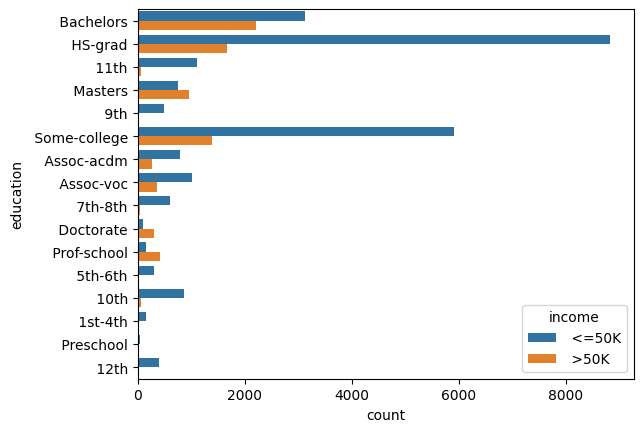

In [ ]:
# What is the distribution of income and highest-level of education?

sns.countplot(y='education', hue='income', data=data_train,)

<Axes: xlabel='count', ylabel='gender'>

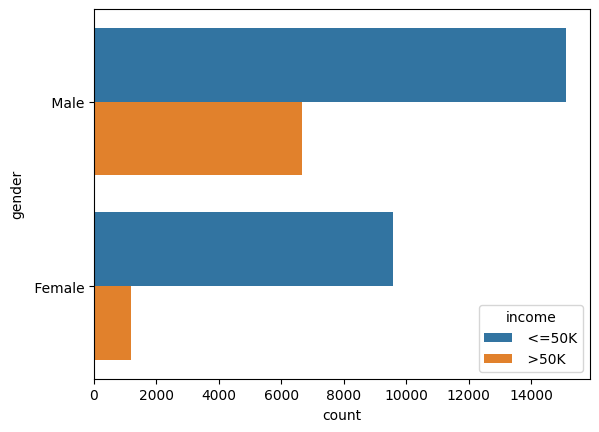

In [ ]:
# What is the distribution of gender and highest-level of education?

sns.countplot(y='gender', hue='income', data=data_train,)

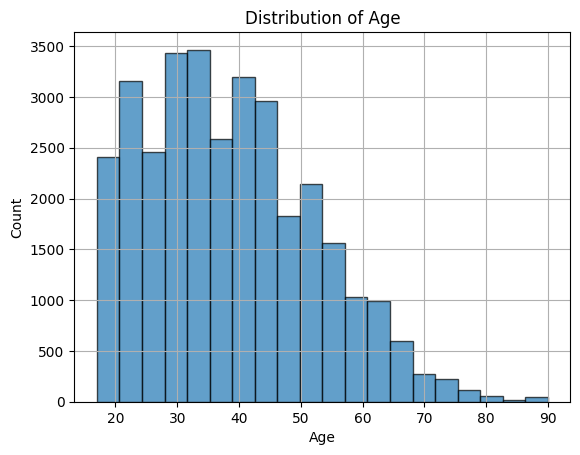

In [ ]:
# What is the distribution of age in this dataset?

plt.hist(data_train['Age'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(True)

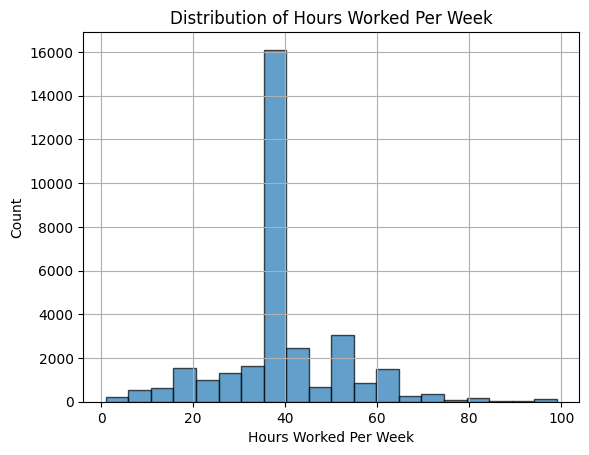

In [ ]:
# What is the distribution of hours worked per week in this dataset?

plt.hist(data_train['hours per week'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Hours Worked Per Week')
plt.xlabel('Hours Worked Per Week')
plt.ylabel('Count')
plt.grid(True)

Next, we will pre-process the dataset. Since some features contain textual values, we will have first to transform them into categorical values. Moreover, the dataset contain some missing values, which given their rare occurance on the dataset we will drop. We will further remove some redundant features from the dataset. The next codeblock apply these pre-processing stages.

In [ ]:
# Drop rows with missing data
missing = data["workclass"][4].values[1]
data = data[data["workclass"] != missing]
data = data[data["occupation"] != missing]
data = data[data["native-country"] != missing]

# Discretisation on column marital_status
data.replace(['Divorced', 'Married-AF-spouse',
              'Married-civ-spouse', 'Married-spouse-absent',
              'Never-married', 'Separated', 'Widowed'],
             ['not married', 'married', 'married', 'married',
              'not married', 'not married', 'not married'], inplace=True)

# Transform categorical fields
category_col = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                'relationship', 'gender', 'native-country', 'income']
for col in category_col:
    b, c = np.unique(data[col], return_inverse=True)
    data[col] = c
datamat = data.values

target = np.array([-1.0 if (val == 0 or val == 1) else 1.0 for val in np.array(datamat)[:, -1]])
datamat = datamat[:, :-1]

# Standardize dataset
scaler = StandardScaler()
scaler.fit(datamat)
datamat = scaler.transform(datamat)

# Generate the final dataframe
data = namedtuple('_', 'data, target')(datamat[:len_train, :], target[:len_train])
data_test = namedtuple('_', 'data, target')(datamat[len_train:, :], target[len_train:])
encoded_data = pd.DataFrame(data.data)
encoded_data['Target'] = (data.target + 1) / 2
encoded_data_test = pd.DataFrame(data_test.data)
encoded_data_test['Target'] = (data_test.target + 1) / 2

# copy the training data into a numpy array
x_train_np = np.array(encoded_data.drop(columns=['Target']))
y_train_np = np.array(encoded_data['Target']).astype(int)
x_test_np = np.array(encoded_data_test.drop(columns=['Target']))
y_test_np = np.array(encoded_data_test['Target']).astype(int)

encoded_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Target
0,0.034201,2.917717,-1.062295,-0.344074,1.128753,0.942936,-1.482624,-0.258387,0.384110,0.693813,0.142888,-0.21878,-0.078120,0.262999,0.0
1,0.866417,1.873997,-1.007438,-0.344074,1.128753,-0.390005,-0.737534,-0.884479,0.384110,0.693813,-0.146733,-0.21878,-2.326738,0.262999,0.0
2,-0.041455,-0.213443,0.245284,0.179902,-0.438122,-1.722946,-0.240806,-0.258387,0.384110,0.693813,-0.146733,-0.21878,-0.078120,0.262999,0.0
3,1.093385,-0.213443,0.425853,-2.439977,-1.221559,-0.390005,-0.240806,-0.884479,-2.018744,0.693813,-0.146733,-0.21878,-0.078120,0.262999,0.0
4,-0.798015,-0.213443,1.407393,-0.344074,1.128753,-0.390005,0.752648,2.245982,-2.018744,-1.441310,-0.146733,-0.21878,-0.078120,-5.329300,0.0


# Building Models With DP

We will train a logistic regression classifier that predicts whether someone's income is >$50K. Specifically, we will compare the accuracy of models with different values of epsilon (which corresponds to amount of privacy guarenteed).

You do not need to change any of the code for this section, **other than your choice of epsilons**.



### Without DP

We start with training a classifier without DP as a baseline.

In [ ]:
# This cell trains a classifier without DP and reports the accuracy.
# You do not need to change any of the code in this cell.

logistic_model = LogisticRegression(max_iter = 250, C = 1/10, warm_start = True)
model_simple = logistic_model.fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])   # Select all columns except the target column

# Report accuracy of model
baseline_acc = model_simple.score(encoded_data_test.drop(columns=['Target']), encoded_data_test['Target'])
print(f"{baseline_acc:.5}", "is the model accuracy without differential privacy")

0.82039 is the model accuracy without differential privacy


### With DP


Now, you will explore the accuracy from using different values of epsilon for differential privacy. Specify your epsilon, and then run the cell below. You may run it multiple times with different values of epsilon.

In [ ]:
# TODO: Pick a value for epsilon
# epsilon = 0.01
# epsilon = 0.1
epsilon = 1.0

## Do not change any of the code below this point.
assert epsilon > 0, "epsilon must be greater than 0"

dp_logistic = dp.LogisticRegression(epsilon=epsilon, C = 1/10)
dp_logistic.fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])
dp_acc = dp_logistic.score(encoded_data_test.drop(columns=['Target']), encoded_data_test['Target'])

print("The accuracy of a DP model with epsilon = {} is {}".format(epsilon, round(dp_acc, 5)))

The accuracy of a DP model with epsilon = 1.0 is 0.81597


### Visualization of accuracy and different epsilon

Run the next code to generate a plot of the performance for different values of $\epsilon$ and then answer the following questions  

100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


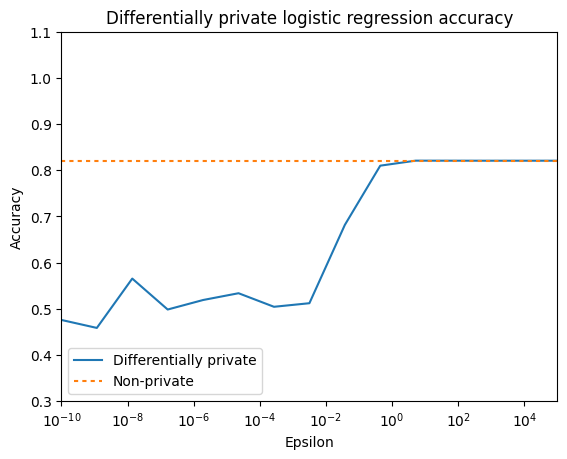

In [ ]:
# TODO: Pick a range of values for epsilon
# You should pick at least 10 different epsilons
# epsilons = np.logspace(X, Y, Z), e.g., np.logspace(-4, 2, 20)
epsilons = np.logspace(-10, 5, 15)

## Do not change any of the code below this point.
## The code below trains a DP model for each of your specified epsilons.
assert len(epsilons)>0, "You must specify more than one epsilon"
assert (e>0 for e in epsilons), "All epsilons must be greater than zero"

accuracy = []
trials_per_epsilon = 10

for eps in tqdm(epsilons):
    curr_acc = 0.0
    for _ in range(trials_per_epsilon):
      dp_clf = dp.LogisticRegression(epsilon=eps, C = 1/10)
      dp_clf.fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])
      curr_acc += dp_clf.score(encoded_data_test.drop(columns=['Target']), encoded_data_test['Target'])

    curr_acc /= trials_per_epsilon
    accuracy.append(curr_acc)

plt.semilogx(epsilons, accuracy, label="Differentially private")
plt.plot(epsilons, np.ones_like(epsilons) * baseline_acc, dashes=[2,2], label="Non-private")
plt.title("Differentially private logistic regression accuracy")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.ylim(0.3, 1.1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=3)
plt.show()

# Membership Inference Attack

The code below implements a membership inference attack on models trained with and without DP. The problem description includes more background on these attacks.


**You do not need to change any of the code below, other than your choice of epsilon.** The code will run the attack on a model trained with that epsilon (use `epsilon=None` to try without DP), and report the accuracy of an attack model that classifies whether points are in the training data or not.

In [ ]:
# TODO: Choose the DP epsilon for the target model that will be attacked
# use epsilon = None to try a target model without DP
epsilon = 1.0

## Do not change any of the code below this point
##################
num_trials = 5
attack_data_size = 0.25
accuracy = 0.0
for trial in tqdm(range(num_trials)):
  # Train a classifier with the specified epsilon (if DP)
  if epsilon == None:
    logistic_model = LogisticRegression(max_iter = 250, C = 1/10)
    dp_logistic = logistic_model.fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])
  else:
    dp_logistic = dp.LogisticRegression(epsilon=epsilon, C = 1/10).fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])

  # Assume the adversary knows samples in and out of the training data that are far away from each other
  kmeans = KMeans(n_clusters=2)
  y_kmeans_train = kmeans.fit_predict(x_train_np)
  y_kmeans_test = kmeans.fit_predict(x_test_np)

  sampled_indices0_train = np.random.choice(np.where(y_kmeans_train == 0)[0], size=int(attack_data_size * x_test_np.shape[0]), replace=True)
  sampled_indices1_train = np.random.choice(np.where(y_kmeans_test == 1)[0], size=int(attack_data_size * x_test_np.shape[0]), replace=True)
  sampled_indices0_test = np.random.choice(np.where(y_kmeans_train == 0)[0], size=int(attack_data_size * x_test_np.shape[0]), replace=True)
  sampled_indices1_test = np.random.choice(np.where(y_kmeans_test == 1)[0], size=int(attack_data_size * x_test_np.shape[0]), replace=True)

  # Create attack dataset: Predict probabilities for both training and test sets
  train_probs_0_dp = dp_logistic.predict_proba(x_train_np[sampled_indices0_train])
  train_probs_1_dp = dp_logistic.predict_proba(x_test_np[sampled_indices1_train])
  test_probs_0_dp  = dp_logistic.predict_proba(x_train_np[sampled_indices0_test])
  test_probs_1_dp  = dp_logistic.predict_proba(x_test_np[sampled_indices1_test])

  train_probs_0_dp = train_probs_0_dp[np.arange(len(y_train_np[sampled_indices0_train])), y_train_np[sampled_indices0_train].ravel()]
  train_probs_1_dp = train_probs_1_dp[np.arange(len(y_test_np[sampled_indices1_train])), y_test_np[sampled_indices1_train].ravel()]
  test_probs_0_dp  = test_probs_0_dp[np.arange(len(y_train_np[sampled_indices0_test])), y_train_np[sampled_indices0_test].ravel()]
  test_probs_1_dp  = test_probs_1_dp[np.arange(len(y_test_np[sampled_indices1_test])), y_test_np[sampled_indices1_test].ravel()]

  # Label the attack dataset: 1 if from the test set and 0 if from the training set
  train_labels_0_dp = np.zeros(len(train_probs_0_dp))
  train_labels_1_dp = np.ones(len(train_probs_1_dp))
  test_labels_0_dp = np.zeros(len(test_probs_0_dp))
  test_labels_1_dp = np.ones(len(test_probs_1_dp))

  X_attack_dp = np.concatenate([train_probs_0_dp, train_probs_1_dp])
  y_attack_dp = np.concatenate([train_labels_0_dp, train_labels_1_dp])
  X_attack_test_dp = np.concatenate([test_probs_0_dp, test_probs_1_dp])
  y_attack_test_dp = np.concatenate([test_labels_0_dp, test_labels_1_dp])

  # Train a random forest classifier
  X_attack_dp = X_attack_dp.reshape(-1, 1)
  X_attack_test_dp = X_attack_test_dp.reshape(-1, 1)
  attack_model = RandomForestClassifier()
  attack_model.fit(X_attack_dp, y_attack_dp)

  # Evaluate the attack model
  y_attack_test_pred = attack_model.predict(X_attack_test_dp)
  accuracy += accuracy_score(y_attack_test_dp, y_attack_test_pred)
if epsilon == None:
  print(f"The attack model accuracy without DP is: {(accuracy/num_trials):.5f}")
else:
  print(f"The attack model accuracy with epsilon = {(epsilon):.5f} is: {(accuracy/num_trials):.5f}")

100%|██████████| 5/5 [00:07<00:00,  1.57s/it]

The attack model accuracy with epsilon = 1.00000 is: 0.80044


# Part 4: Unlearning

We will now implement a simple unlearning algorithm, with the aim to reverse the influence of a subset of samples on the model.

**You do not need to change any of the code below, other than your choice of the number of samples to unlearn.** The code will then try to unlearn these samples, and report the accuracy of the resulting model and the membership inference attack.

In [ ]:
# ToDo: choose different number of samples to unlearn (number of samples should be >100)
# number_of_samples_to_unlearn = 500
number_of_samples_to_unlearn = 10000

## Do not change any of the code below this point
##################
assert number_of_samples_to_unlearn>100, "Number of samples to unlearn should be >100"

# Pick random subset of samples and remove them from the train set
sampled_indices0_train = np.where(y_kmeans_train == 0)[0]
if number_of_samples_to_unlearn > len(sampled_indices0_train):
  number_of_samples_to_unlearn = len(sampled_indices0_train)
elif number_of_samples_to_unlearn > len(np.where(y_kmeans_test == 1)[0]):
  number_of_samples_to_unlearn = len(np.where(y_kmeans_test == 1)[0])
samples_to_unlearn = np.random.choice(sampled_indices0_train.shape[0], number_of_samples_to_unlearn, replace=False)

# Create the subset containing only the selected samples
forget_set_x = x_train_np[sampled_indices0_train[samples_to_unlearn]]
forget_set_y = y_train_np[sampled_indices0_train[samples_to_unlearn]]

# Create the remaining subset by excluding the selected samples
remaining_indices = np.setdiff1d(np.arange(x_train_np.shape[0]), sampled_indices0_train[samples_to_unlearn])
retain_set_x = x_train_np[remaining_indices]
retain_set_y = y_train_np[remaining_indices]

# initiate a logistic regression model, train on the entire set of data and then continue its training on the retain set, to forget the forget set
logistic_model = LogisticRegression(max_iter = 250, C = 1/10, warm_start = True, tol=1e-10, solver = 'lbfgs')
model_simple = logistic_model.fit(encoded_data.drop(columns=['Target']), encoded_data['Target'])   # Select all columns except the target column
model_simple.set_params(max_iter=100).fit(retain_set_x, retain_set_y)

# accuracy after unlearning
accuracy_unlearning = model_simple.score(encoded_data_test.drop(columns=['Target']), encoded_data_test['Target'])
print("The model accuracy after unlearning is: {}".format(accuracy_unlearning))

# MIA after unlearning: pick the unlearnt samples and samples from test set, and try to classify between them
sampled_indices1_train = np.random.choice(np.where(y_kmeans_test == 1)[0], size=int(number_of_samples_to_unlearn/2), replace=False)
sampled_indices1_test = np.random.choice(np.where(y_kmeans_test == 1)[0], size=int(number_of_samples_to_unlearn/2), replace=False)
train_probs_0_dp = model_simple.predict_proba(forget_set_x[:int(number_of_samples_to_unlearn/2)])
train_probs_1_dp = model_simple.predict_proba(x_test_np[sampled_indices1_train])
test_probs_0_dp  = model_simple.predict_proba(forget_set_x[int(number_of_samples_to_unlearn/2):])
test_probs_1_dp  = model_simple.predict_proba(x_test_np[sampled_indices1_test])

train_probs_0_dp = train_probs_0_dp[np.arange(len(forget_set_y[:int(number_of_samples_to_unlearn/2)])), forget_set_y[:int(number_of_samples_to_unlearn/2)].ravel()]
train_probs_1_dp = train_probs_1_dp[np.arange(len(y_test_np[sampled_indices1_train])), y_test_np[sampled_indices1_train].ravel()]
test_probs_0_dp  = test_probs_0_dp[np.arange(len(forget_set_y[int(number_of_samples_to_unlearn/2):])), forget_set_y[int(number_of_samples_to_unlearn/2):].ravel()]
test_probs_1_dp  = test_probs_1_dp[np.arange(len(y_test_np[sampled_indices1_test])), y_test_np[sampled_indices1_test].ravel()]

# Label the attack dataset: 1 if from the test set and 0 if from the training set
train_labels_0_dp = np.zeros(len(train_probs_0_dp))
train_labels_1_dp = np.ones(len(train_probs_1_dp))
test_labels_0_dp = np.zeros(len(test_probs_0_dp))
test_labels_1_dp = np.ones(len(test_probs_1_dp))

X_attack_dp = np.concatenate([train_probs_0_dp, train_probs_1_dp])
y_attack_dp = np.concatenate([train_labels_0_dp, train_labels_1_dp])
X_attack_test_dp = np.concatenate([test_probs_0_dp, test_probs_1_dp])
y_attack_test_dp = np.concatenate([test_labels_0_dp, test_labels_1_dp])

# Train a random forest classifier
X_attack_dp = X_attack_dp.reshape(-1, 1)
X_attack_test_dp = X_attack_test_dp.reshape(-1, 1)
attack_model = RandomForestClassifier()
attack_model.fit(X_attack_dp, y_attack_dp)

# Evaluate the previous attack model, on sample from the test set and samples that we unlearnt
y_attack_test_pred = attack_model.predict(X_attack_test_dp)
accuracy = accuracy_score(y_attack_test_dp, y_attack_test_pred)

print(f"The accuracy of the membership inference attack is: {(accuracy):.2f}")

The model accuracy after unlearning is: 0.8256851749466867
The accuracy of the membership inference attack is: 0.83
